In [1]:
# Implementing a U-net network on Bagls dataset.

import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from natsort import natsorted

import keras
from keras.models import *
from keras.layers import *
from keras.optimizers import *

import albumentations as A
from PIL import Image
from sklearn.model_selection import train_test_split

from scipy.ndimage import gaussian_filter


C:\Users\ve59kedo\.conda\envs\HUNet\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.25.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [ ]:
from PIL import Image
import numpy as np
import os

# Specify input and output folder paths
input_folder = './output_images'
output_folder = './output_images_np'

# Function to convert a JPEG file to a NumPy array
def jpeg_to_numpy(file_path):
    img = Image.open(file_path)
    img_array = np.array(img)
    return img_array

# Loop through files in the input folder
for filename in os.listdir(input_folder):
    if filename.endswith('.png'):
        input_file_path = os.path.join(input_folder, filename)
        output_file_path = os.path.join(output_folder, filename)

        # Convert JPEG to NumPy array
        numpy_array = jpeg_to_numpy(input_file_path)

        # Save the NumPy array as a .npy file in the output folder
        np.save(output_file_path[:-4] + '.npy', numpy_array)

# Now, the NumPy arrays are saved as .npy files in the output folder with the same names as the original JPEG files


In [3]:
data_dir = './output_images_np'
tile_size1 = (256,256)
tile_size2 = (256,256,1)
input_shape = (256,256,3)

 
x = []
y = []

for filename in natsorted(os.listdir(data_dir)):

    if filename.endswith('labelled.npy'):
        y.append(os.path.join(data_dir, filename))
        
    if filename.endswith('].npy'):
        x.append(os.path.join(data_dir, filename))   
        

import numpy as np
from PIL import Image

# List to store the paths of images with unique classes
full_set_y = []
full_set_x = []       
counter = 0

# Create a copy of the original 'y' list
y_copy = y.copy()

# Loop through the dataset represented by 'y_copy'
unique_classes_encountered = set()
total_pixels = 256 * 256

for i in range(len(y)):
    lbl_arr_path = y[i]

    # Check if the image contains at least one unique class from 1 to 12
    img = np.load(lbl_arr_path)
    unique_classes = np.unique(img)
    unique_classes_1_to_12 = [cls for cls in unique_classes if 1 <= cls <= 12]
    for cls in unique_classes_1_to_12:
        # Append the path to the full_set_y list
        img_clc = (img == cls)

        # Step 1: Count the number of ones using numpy
        num_ones = np.sum(img_clc == 1)

        # Step 2: Calculate percentage
        percentage_ones = (num_ones / total_pixels) * 100.
        if percentage_ones >= 8.0:
            full_set_y.append(lbl_arr_path)
            break
        else:
            counter += 1

for mask_path in full_set_y:
    # Remove the '-labelled' from the mask path
    image_path = mask_path.replace('-labelled', '')
    full_set_x.append(image_path)         
                   
X_train, X_test, Y_train, Y_test = train_test_split(full_set_x, full_set_y, test_size=0.15, random_state=42)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.18, random_state=42)

print("Dataset Sizes:")
print(f"killed {counter} unpure samples")
print(f"Training set: {len(X_train)} samples = {((len(X_train)/len(full_set_x))*100):.2f}%")
print(f"Validation set: {len(X_val)} samples = {((len(X_val)/len(full_set_x))*100):.2f}%")
print(f"Test set: {len(X_test)} samples = {((len(X_test)/len(full_set_x))*100):.2f}%")

Dataset Sizes:
killed 3 unpure samples
Training set: 83 samples = 69.17%
Validation set: 19 samples = 15.83%
Test set: 18 samples = 15.00%


In [3]:
import numpy as np
from PIL import Image

# List to store the paths of images with unique classes
full_set_y = []
full_set_x = []

# Set to store the unique classes that have been encountered


for num in range(10):
    unique_image_paths = []
    image_paths = []
    unique_classes_encountered = set()

    for i in range(len(y)):
        lbl_arr_path = y[i]

        # Check if the image contains at least one unique class from 1 to 12
        unique_classes = np.unique(np.array(Image.open(lbl_arr_path)))
        unique_classes_1_to_12 = [cls for cls in unique_classes if 1 <= cls <= 12]

        for cls in unique_classes_1_to_12:
            if cls not in unique_classes_encountered:
                # Append the path to the unique_image_paths list
                img = np.array(Image.open(lbl_arr_path))
                img = (img == cls).astype(int)
                
                # Step 1: Count the number of zeros and ones using numpy
                num_ones = np.sum(img == 1)

                # Step 2: Calculate percentages
                total_pixels = 256 * 256
                percentage_ones = (num_ones / total_pixels) * 100

                if percentage_ones >= 10.0:
                    unique_image_paths.append(lbl_arr_path)
                    # Add the unique class to the set of encountered classes
                    unique_classes_encountered.add(cls)
                    break

    # Print the list of paths for images with unique classes

    for mask_path in unique_image_paths:
        # Remove the '-labelled' from the mask path
        image_path = mask_path.replace('-labelled', '')
        image_paths.append(image_path)

    full_set_y.extend(unique_image_paths)
    full_set_x.extend(image_paths)

    # Remove the elements from y after the loop
    indices_to_remove = []
    for i in range(len(unique_image_paths)):
        index = y.index(unique_image_paths[i])
        indices_to_remove.append(index)

    indices_to_remove.sort(reverse=True)

    for index in indices_to_remove:
        y.pop(index)
    print(f'+{num}')



+0
+1
+2
+3
+4
+5
+6
+7
+8
+9


In [6]:
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'

    def __init__(self, list_IDs, list_labels, batch_size=2, shuffle=True, aug=True,num_class=4,remove_bg=0):
        'Initialization'
        self.filter = A.Compose([
            A.HorizontalFlip(p=0.2),
            A.RandomBrightnessContrast(p=0.2),
            A.VerticalFlip(p=0.2),
            A.RandomRotate90(p=0.1)
        ])
        self.class_names = [
            'Not_annotated',
            'Tumor_Verhornung',
            'All_Other',
            'White_BG'
        ]
        self.batch_size = batch_size
        self.list_labels = list_labels
        self.list_IDs = list_IDs
        self.shuffle = shuffle
        self.aug = aug
        self.num_class = num_class
        self.remove_bg = remove_bg
        self.unique = np.arange(0, 12, 1)
        if self.remove_bg:
            self.class_names = self.class_names[1:]
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index * self.batch_size: (index + 1) * self.batch_size]

        # Find list of IDs
        list_IDs_paths = [self.list_IDs[k] for k in indexes]
        list_label_paths = [self.list_labels[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_paths, list_label_paths)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_paths, list_label_paths):
        'Generates data containing batch_size samples' # X: (n_samples, *dim, n_channels)
        # Initialization
        x_images = []
        y_images = []

        # Generate data
        for i, (sample_path, label_path) in enumerate(zip(list_IDs_paths, list_label_paths)):
            # Store sample
            img_arr = np.load(sample_path)
            img_arr = np.resize(img_arr, (256,256,3))
            img_arr = np.array(img_arr, dtype=np.float32)
            img_arr /= 255.0 # normalize

            # Store label
            lbl_arr = np.load(label_path)
            lbl_arr = np.resize(lbl_arr, (256,256))
            channels = np.zeros((np.shape(lbl_arr)[0], np.shape(lbl_arr)[1], self.num_class), dtype=np.float32)

            for i, value in enumerate(self.unique):
                if value in [1]:  # Class 1: Tumor,
                    channels[:, :, 1] += (lbl_arr == value).astype(np.uint8)
                elif value == 0:  # Class 0: Not annotated
                    channels[:, :, 0] = (lbl_arr == value).astype(np.uint8)
                elif value in [2, 3, 4, 5, 6, 7, 9, 10, 11, 12]:  # All other classes
                    channels[:, :, 2] += (lbl_arr == value).astype(np.uint8)
                    
                    

            # Apply Gaussian smoothing with a specified sigma (adjust sigma as needed)
            sigma = 8.0
            img_arr_smoothed = gaussian_filter(img_arr, sigma=sigma)

            # Threshold the image to make white pixels more visible
            threshold = 0.75
            img_arr_smoothed = np.mean(img_arr_smoothed,axis=2)
            img_arr_smoothed[img_arr_smoothed >= threshold] = 1.0
            img_arr_smoothed[img_arr_smoothed < threshold] = 0.0


            channels[:,:,-1] = img_arr_smoothed

            for i in range(0, self.num_class - 1):

                # Perform a bitwise AND operation to get the overlapping region
                overlap = (channels[:, :, i].astype(bool) & img_arr_smoothed.astype(bool)).astype(np.uint8)

                # Perform a bitwise XOR operation to delete the overlapping region from mask1
                channels[:, :, i] = (channels[:, :, i].astype(bool) ^ overlap).astype(np.uint8)

            lbl_arr = channels
            lbl_arr[lbl_arr < 1] = 0
            lbl_arr[lbl_arr >= 1] = 1

            if self.aug:
                transformed = self.filter(image=img_arr, mask=lbl_arr)
                x_images.append(transformed['image'])
                y_images.append(transformed['mask'])
            else:
                x_images.append(img_arr)
                y_images.append(lbl_arr)

        # Stack x_images along a new axis
        x_images = np.stack(x_images, axis=0)
        y_images = np.stack(y_images, axis=0)

        return x_images, y_images

    def viz(self, x_images, y_images):
        'Visualizes original and transformed images'
        batch_size = len(x_images)
        for dx in range(batch_size):
            y_mask = y_images[dx]

            # Display original and transformed images side by side
            fig, axs = plt.subplots(1, len(self.class_names)+1, figsize=(20, 10))

            axs[0].imshow(x_images[dx])
            axs[0].set_title('img')
            axs[0].axis('off')

            for i in range(0, len(self.class_names)):
                axs[i+1].imshow(y_mask[:, :, i])
                axs[i+1].axis('off')  # Remove axes
                axs[i+1].set_title(f'{self.class_names[i]}_{i}', fontsize=9)
            plt.show()

        print(f'Batch shape {np.shape(x_images)} and for masks {np.shape(y_images)}')
        print(f'image shape {np.shape(x_images[dx])} and for masks {np.shape(y_images[dx])}')
        print(f'max value for images is {np.max(x_images[dx])} and for masks {np.max(y_images[dx])}')
        print(f'min value for images is {np.min(x_images[dx])} and for masks {np.min(y_images[dx])}')
        print(f'number of unique values in images is {len(np.unique(x_images[dx]))} and for masks {np.unique(y_images[dx])}')
    
    

In [10]:
test = DataGenerator(full_set_x,full_set_y,batch_size=12,aug=0,remove_bg=0)
a,b = test.__getitem__(0)
#test.viz(a,b)


(119, 119)

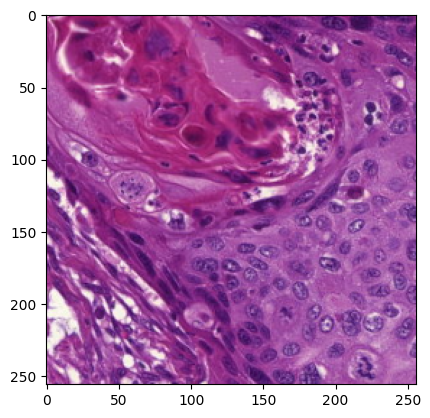

In [92]:
plt.imshow(a[8])
call_test1 = a[8]
call_test2 = b[8]
a = np.delete(a, 8, axis=0)
b = np.delete(b, 8, axis=0)
len(a),len(b)


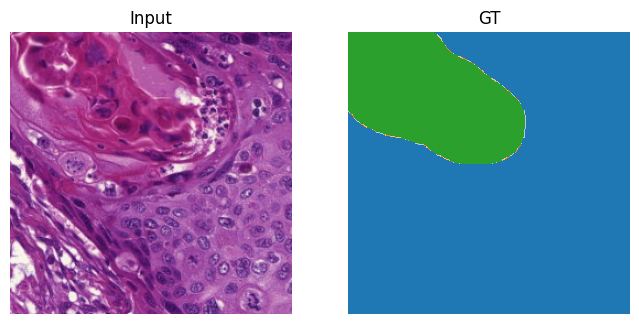

In [103]:
fig, ax = plt.subplots(1, 2, figsize=(8, 6))

ax[0].imshow(call_test1)

empty = np.zeros((256, 256))
# Loop through the images and plot them
ans = np.argmax(call_test2,axis=2)

# Create a custom discrete colormap with 13 colors
cmap = ListedColormap(plt.cm.tab20.colors[:14])
bounds = np.arange(0, 15) -0.5 # Set boundaries of color segments
norm = BoundaryNorm(bounds, cmap.N)
ax[1].axis('off')
ax[0].axis('off')
im = ax[1].imshow(ans, cmap=cmap, norm=norm)
ax[1].set_title('GT')
ax[0].set_title('Input')
plt.savefig('./GIF/GT',)


In [106]:
from keras.optimizers import SGD
from keras.optimizers import Adam

SGD = SGD(lr=0.1, momentum=0.9)
Adam = Adam(learning_rate=0.1,beta_1=0.99)
WDL = DiceLoss(class_weights=class_weights)
Wcat = CategoricalCELoss(class_weights=class_weights)

expriemtns = [[SGD,WDL],[SGD,Wcat],[Adam,WDL],[Adam,Wcat]]
counter = 0 
for exp in expriemtns: 
    from tensorflow.keras.layers import Add
    
    fil = 32
    inputs = Input(input_shape)

    # Contractive
    conv1 = Conv2D(fil, 3, activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
    conv2 = Conv2D(fil, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
    conv2 = BatchNormalization()(conv2)
    skip1 = Add()([conv1, conv2])
    pool1 = MaxPooling2D(pool_size=(2, 2))(skip1)

    conv3 = Conv2D(fil * 2, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool1)
    conv4 = Conv2D(fil * 2, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv3)
    conv4 = BatchNormalization()(conv4)
    skip2 = Add()([conv3, conv4])
    pool2 = MaxPooling2D(pool_size=(2, 2))(skip2)

    conv5 = Conv2D(fil * 4, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool2)
    conv6 = Conv2D(fil * 4, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv5)
    conv6 = BatchNormalization()(conv6)
    skip3 = Add()([conv5, conv6])
    pool3 = MaxPooling2D(pool_size=(2, 2))(skip3)

    conv7 = Conv2D(fil * 8, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool3)
    conv8 = Conv2D(fil * 8, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv7)
    conv8 = BatchNormalization()(conv8)
    skip4 = Add()([conv7, conv8])
    pool4 = MaxPooling2D(pool_size=(2, 2))(skip4)

    conv9 = Conv2D(fil * 16, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool4)
    conv10 = Conv2D(fil * 16, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)
    conv10 = BatchNormalization()(conv10)
    skip5 = Add()([conv9, conv10])


    # Expansive
    upconv1 = Conv2D(fil * 8, 2, activation='relu', padding='same', kernel_initializer='he_normal')(skip5)
    up6 = UpSampling2D(size=(2, 2))(upconv1)
    merge6 = concatenate([skip4, up6], axis=3)
    conv6 = Conv2D(fil * 8, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge6)
    conv6 = Conv2D(fil * 8, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv6)
    conv6 = BatchNormalization()(conv6)

    upconv2 = Conv2D(fil * 8, 2, activation='relu', padding='same', kernel_initializer='he_normal')(conv6)
    up7 = UpSampling2D(size=(2, 2))(upconv2)
    merge7 = concatenate([skip3, up7], axis=3)
    conv7 = Conv2D(fil * 4, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge7)
    conv7 = Conv2D(fil * 4, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv7)
    conv7 = BatchNormalization()(conv7)

    upconv3 = Conv2D(fil * 4, 2, activation='relu', padding='same', kernel_initializer='he_normal')(conv7)
    up8 = UpSampling2D(size=(2, 2))(upconv3)
    merge8 = concatenate([skip2, up8], axis=3)
    conv8 = Conv2D(fil * 2, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge8)
    conv8 = Conv2D(fil * 2, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv8)
    conv8 = BatchNormalization()(conv8)

    upconv4 = Conv2D(fil * 2, 2, activation='relu', padding='same', kernel_initializer='he_normal')(conv8)
    up9 = UpSampling2D(size=(2, 2))(upconv4)
    merge9 = concatenate([skip1, up9], axis=3)
    conv9 = Conv2D(fil, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge9)
    conv9 = Conv2D(fil, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)
    conv9 = BatchNormalization()(conv9)

    conv10 = Conv2D(14, 1, activation='softmax')(conv9)

    model = Model(inputs=inputs, outputs=conv10)

    def count_ones_per_channel(mask_list):
        num_channels = mask_list[0].shape[-1]
        result = [0] * num_channels

        for mask in mask_list:
            for channel in range(num_channels):
                result[channel] += np.sum(mask[..., channel])

        return np.array(result)
    class_occurrences = count_ones_per_channel(b)

    class_weights = np.sum(class_occurrences) / (14 * class_occurrences)

    class_weights[0] = 0.0
    print(f'class weights = {class_weights}')

    from segmentation_models.losses import *
    from segmentation_models.metrics import *

    WDL = DiceLoss(class_weights=class_weights)
    metric = IOUScore()

    Wcat = CategoricalCELoss(class_weights=class_weights)


    IOUscore0 = IOUScore(class_indexes=0, name='IOU_Not_Annotated')
    IOUscore1 = IOUScore(class_indexes=1, name='IOU_Tumor')
    IOUscore2 = IOUScore(class_indexes=2, name='IOU_Stroma')
    IOUscore3 = IOUScore(class_indexes=3, name='IOU_Necrosis')
    IOUscore4 = IOUScore(class_indexes=4, name='IOU_Verhornung')
    IOUscore5 = IOUScore(class_indexes=5, name='IOU_Blut')
    IOUscore6 = IOUScore(class_indexes=6, name='IOU_Lockeres_Bindegewebe')
    IOUscore7 = IOUScore(class_indexes=7, name='IOU_Zellreiches_Stroma')
    IOUscore8 = IOUScore(class_indexes=8, name='IOU_Fettgewebe')
    IOUscore9 = IOUScore(class_indexes=9, name='IOU_Muskel')
    IOUscore10 = IOUScore(class_indexes=10, name='IOU_Cauter')
    IOUscore11 = IOUScore(class_indexes=11, name='IOU_Muskel_längs')
    IOUscore12 = IOUScore(class_indexes=12, name='IOU_Nerv')
    IOUscore13 = IOUScore(class_indexes=13, name='IOU_White_BG')

    from keras.callbacks import Callback


    class PredictionCallback(Callback):
        def __init__(self, model, input_image, output_path, num_classes):
            self.model = model
            self.input_image = input_image
            self.output_path = output_path
            self.num_classes = num_classes
            self.predictions = []

        def on_epoch_end(self, epoch, logs=None):
            prediction = self.model.predict(np.expand_dims(self.input_image, axis=0))[0]
            self.predictions.append(prediction)

    prediction_callback = PredictionCallback(model, call_test, './GIF', 14)

    from keras.optimizers import SGD
    from keras.callbacks import ReduceLROnPlateau
    from tensorflow.keras.optimizers import Adam


    reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=15)

    setup = counter

    # Update the loss in model compilation
    model.compile(optimizer=exp[0],
                  loss=exp[1],   # Updated loss function
                  metrics=[
                      IOUscore0,
                      IOUscore1,
                      IOUscore2,
                      IOUscore3,
                      IOUscore4,
                      IOUscore5,
                      IOUscore6,
                      IOUscore7,
                      IOUscore8,
                      IOUscore9,
                      IOUscore10,
                      IOUscore11,
                      IOUscore12,
                      IOUscore13,
                  ])


    history = model.fit(a,b,
                        epochs=400,
                        callbacks=[reduce_lr,prediction_callback]
                        )

    import numpy as np
    import matplotlib.pyplot as plt
    from matplotlib.colors import ListedColormap
    import imageio

    # Assuming you have class_names defined as a list of class names
    image_paths = []

    for idx in range(len(prediction_callback.predictions)):
        ans = np.argmax(prediction_callback.predictions[idx], axis=2)
        cmap = ListedColormap(plt.cm.tab20.colors[:14])

        # Set up the figure and axes
        fig, ax = plt.subplots(1, 1, figsize=(8, 8))
        ax.axis('off')

        # Plot the prediction
        im = ax.imshow(ans, cmap=cmap, vmin=-0.5, vmax=13.5)
        ax.set_title(f'Prediction - Epoch {idx + 1}')

        # Add colorbar next to the plot
        cbar = plt.colorbar(im, ax=ax, ticks=np.arange(0, 14), shrink=0.7)
        cbar.set_ticklabels(class_names)

        # Save the current plot as an image
        image_path = f'./trash/{setup}_plot_{idx}.png'
        plt.savefig(image_path, bbox_inches='tight')
        image_paths.append(image_path)
        plt.close()

    # Create GIF from saved images
    gif_path = f'./GIF/{setup}.gif'
    images = [imageio.imread(image_path) for image_path in image_paths]
    imageio.mimsave(gif_path, images, duration=0.2)  # Adjust duration as needed
    counter = counter + 1


class weights = [0.         1.76928366 2.6843613  1.86219063 4.34394981 3.14111123
 4.31819098 2.1942521  4.48214257 2.52720984 2.60780959 2.71404804
 3.32878509 1.51985328]
Epoch 1/400
4/4 [==============================] - 3s 330ms/step - loss: 0.8732 - IOU_Not_Annotated: 0.0719 - IOU_Tumor: 0.0228 - IOU_Stroma: 0.0195 - IOU_Necrosis: 0.0201 - IOU_Verhornung: 0.0237 - IOU_Blut: 0.0442 - IOU_Lockeres_Bindegewebe: 0.0165 - IOU_Zellreiches_Stroma: 0.0443 - IOU_Fettgewebe: 0.0225 - IOU_Muskel: 0.0166 - IOU_Cauter: 0.0178 - IOU_Muskel_längs: 0.0160 - IOU_Nerv: 0.0220 - IOU_White_BG: 0.0638 - lr: 0.1000
Epoch 2/400
4/4 [==============================] - 1s 266ms/step - loss: 0.7303 - IOU_Not_Annotated: 0.0845 - IOU_Tumor: 0.0507 - IOU_Stroma: 0.0262 - IOU_Necrosis: 0.0229 - IOU_Verhornung: 0.0962 - IOU_Blut: 0.1216 - IOU_Lockeres_Bindegewebe: 0.0259 - IOU_Zellreiches_Stroma: 0.0871 - IOU_Fettgewebe: 0.0480 - IOU_Muskel: 0.0128 - IOU_Cauter: 0.0352 - IOU_Muskel_längs: 0.0143 - IOU_Nerv: 0.0

C:\Users\ve59kedo\AppData\Local\Temp\ipykernel_36628\375334639.py:205: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images = [imageio.imread(image_path) for image_path in image_paths]


class weights = [0.         1.76928366 2.6843613  1.86219063 4.34394981 3.14111123
 4.31819098 2.1942521  4.48214257 2.52720984 2.60780959 2.71404804
 3.32878509 1.51985328]
Epoch 1/400
4/4 [==============================] - 3s 336ms/step - loss: 0.2136 - IOU_Not_Annotated: 0.0738 - IOU_Tumor: 0.0290 - IOU_Stroma: 0.0201 - IOU_Necrosis: 0.0180 - IOU_Verhornung: 0.0178 - IOU_Blut: 0.0068 - IOU_Lockeres_Bindegewebe: 0.0197 - IOU_Zellreiches_Stroma: 0.0157 - IOU_Fettgewebe: 0.0302 - IOU_Muskel: 0.0198 - IOU_Cauter: 0.0234 - IOU_Muskel_längs: 0.0136 - IOU_Nerv: 0.0133 - IOU_White_BG: 0.0101 - lr: 3.9063e-04
Epoch 2/400
4/4 [==============================] - 1s 271ms/step - loss: 0.2132 - IOU_Not_Annotated: 0.0735 - IOU_Tumor: 0.0268 - IOU_Stroma: 0.0197 - IOU_Necrosis: 0.0184 - IOU_Verhornung: 0.0179 - IOU_Blut: 0.0071 - IOU_Lockeres_Bindegewebe: 0.0203 - IOU_Zellreiches_Stroma: 0.0181 - IOU_Fettgewebe: 0.0290 - IOU_Muskel: 0.0211 - IOU_Cauter: 0.0210 - IOU_Muskel_längs: 0.0136 - IOU_Nerv:

C:\Users\ve59kedo\AppData\Local\Temp\ipykernel_36628\4012795060.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images = [imageio.imread(image_path) for image_path in image_paths]


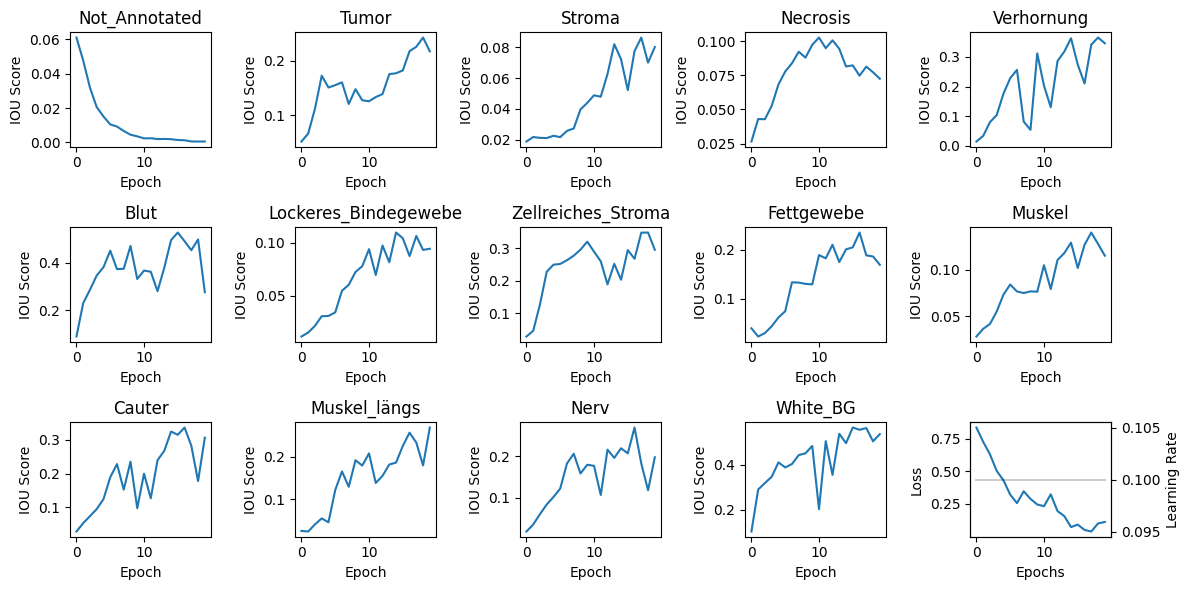

In [43]:
#how was the network on each epoch?

class_names = [
            'Not_Annotated',
            'Tumor',
            'Stroma',
            'Necrosis',
            'Verhornung',
            'Blut',
            'Lockeres_Bindegewebe',
            'Zellreiches_Stroma',
            'Fettgewebe',
            'Muskel',
            'Cauter',
            'Muskel_längs',
            'Nerv',
            'White_BG',
            ]


fig, axes = plt.subplots(3, 5, figsize=(12, 6))
axes = axes.flatten()

for i, class_name in enumerate(class_names):
    metric_name = 'IOU_' + class_name
    axes[i].plot(history.history[metric_name])
    axes[i].set_title(class_name)
    axes[i].set_xlabel('Epoch')
    axes[i].set_ylabel('IOU Score')


axes[14].plot(history.history['loss'], label='loss')
axes[14].set_xlabel('Epochs')
axes[14].set_ylabel('Loss')

# Plot the second dataset
ax2 = axes[14].twinx()

ax2.plot(history.history['lr'], label='lr', color='black',alpha=0.2)
ax2.set_ylabel('Learning Rate')



plt.tight_layout()
#plt.savefig('./14class_OF_adam_beta0.9_Category_.png') 

plt.show()

1/1 [==============================] - 0s 288ms/step


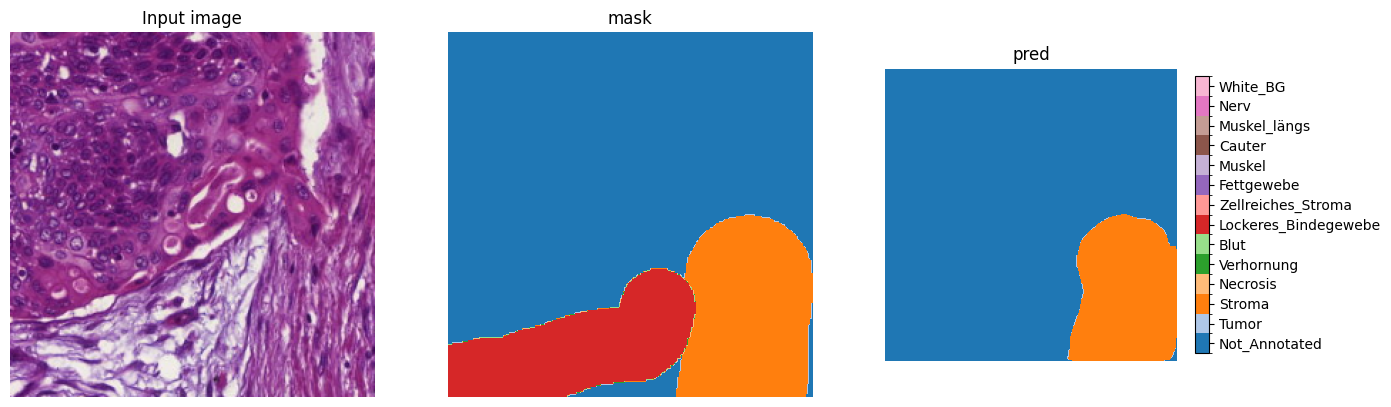

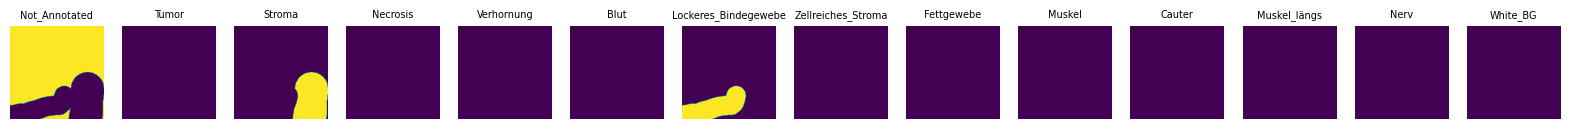

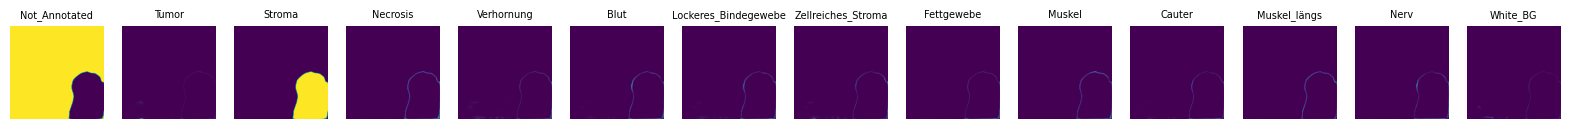

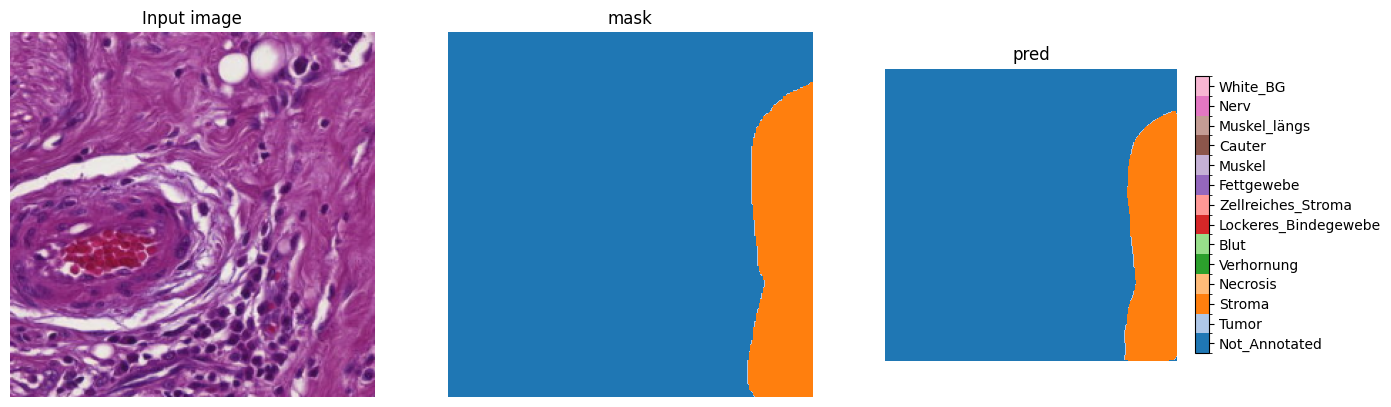

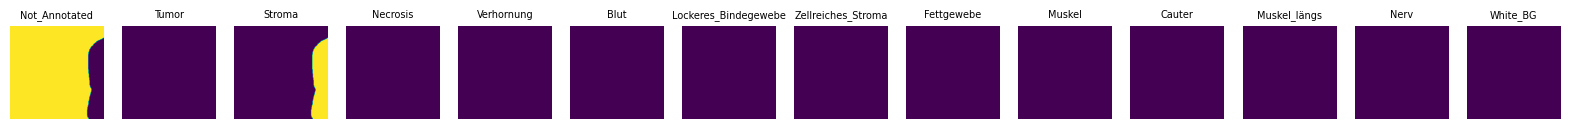

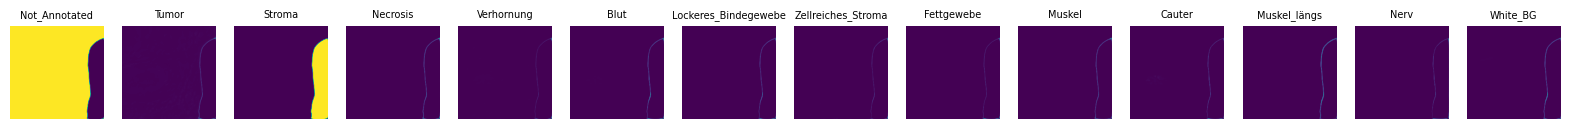

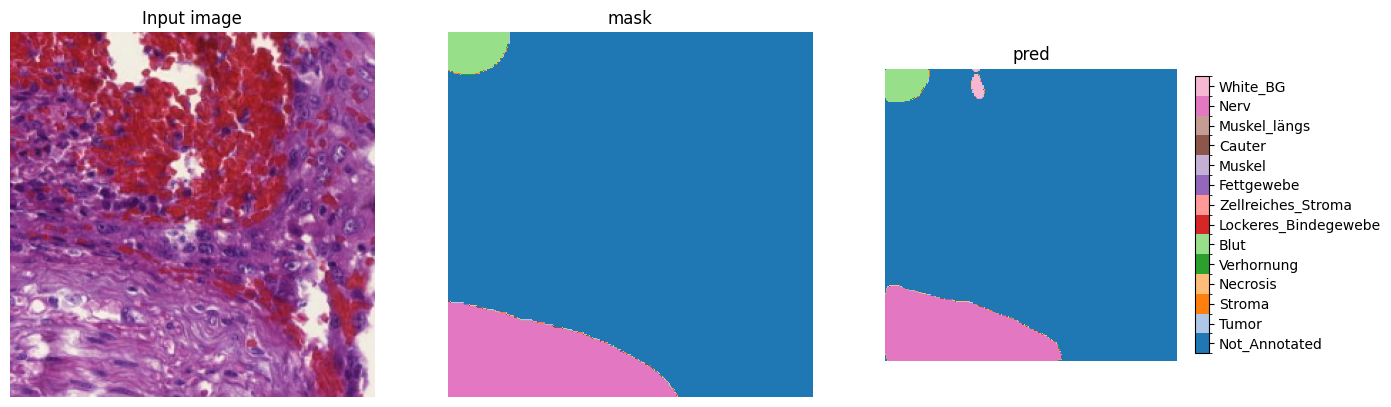

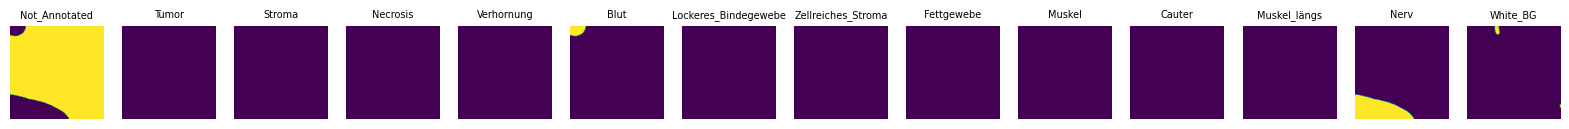

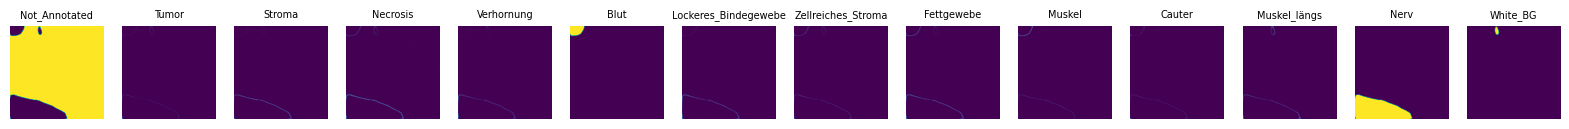

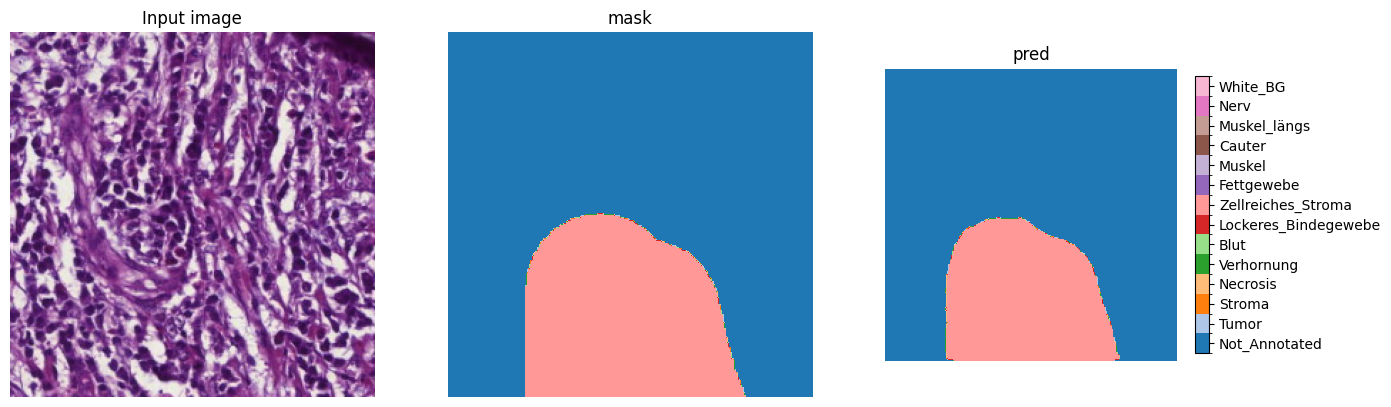

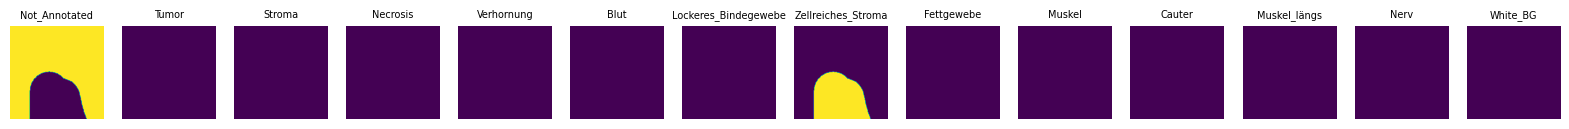

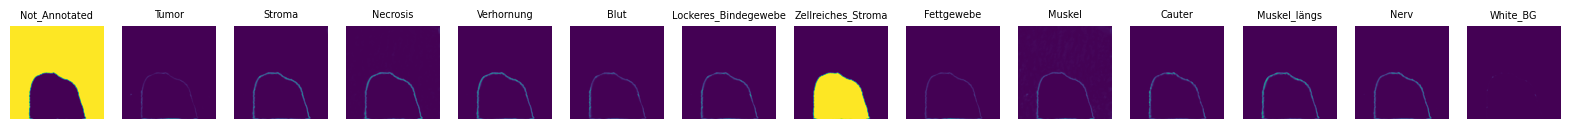

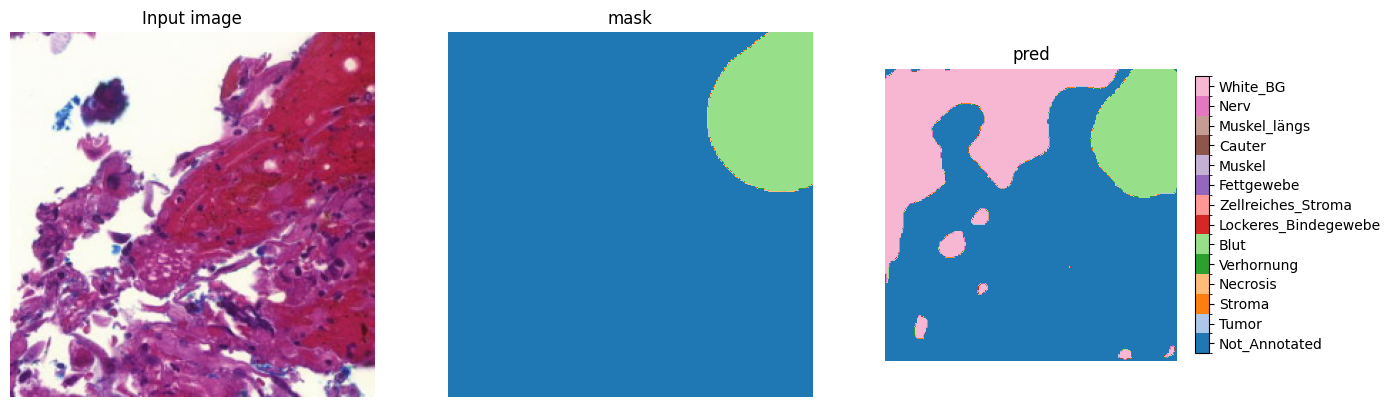

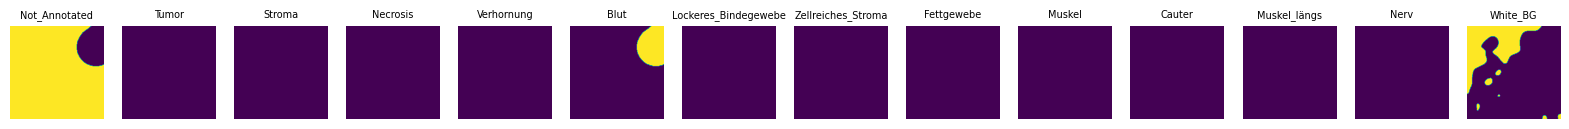

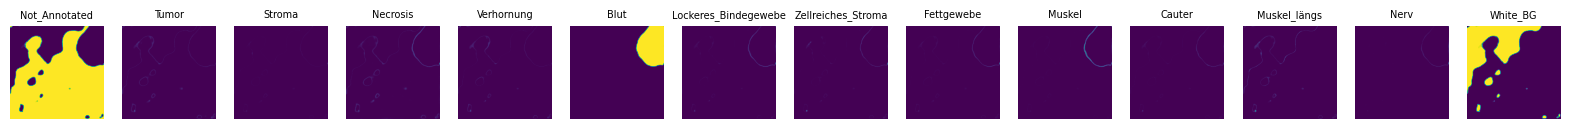

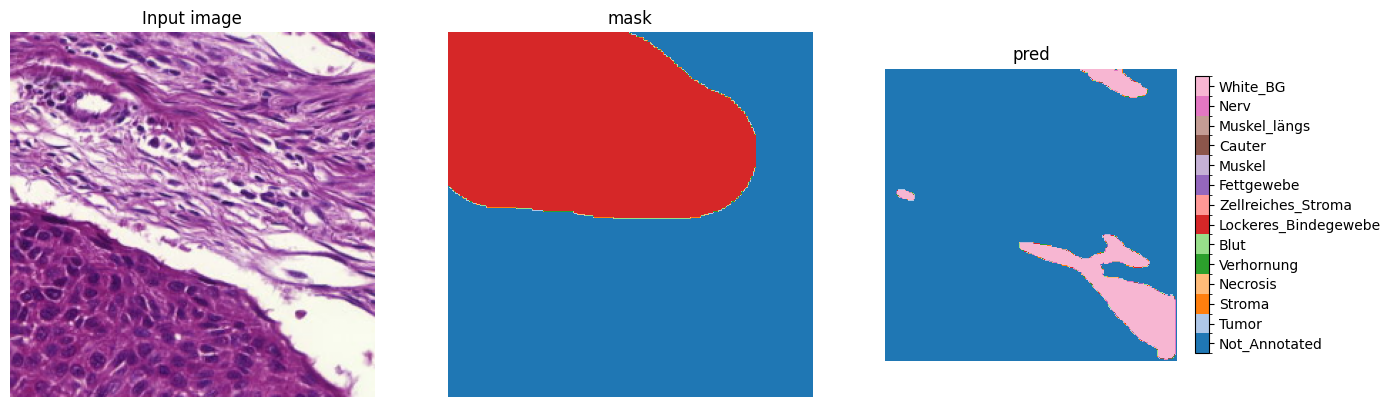

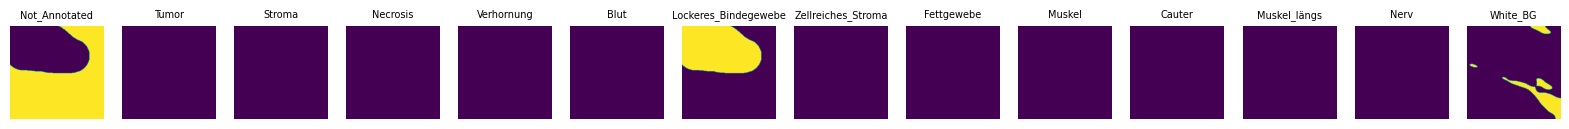

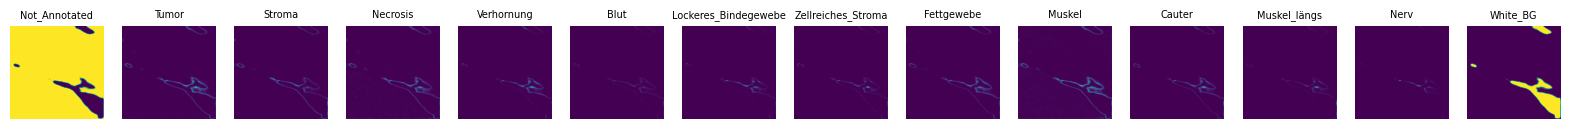

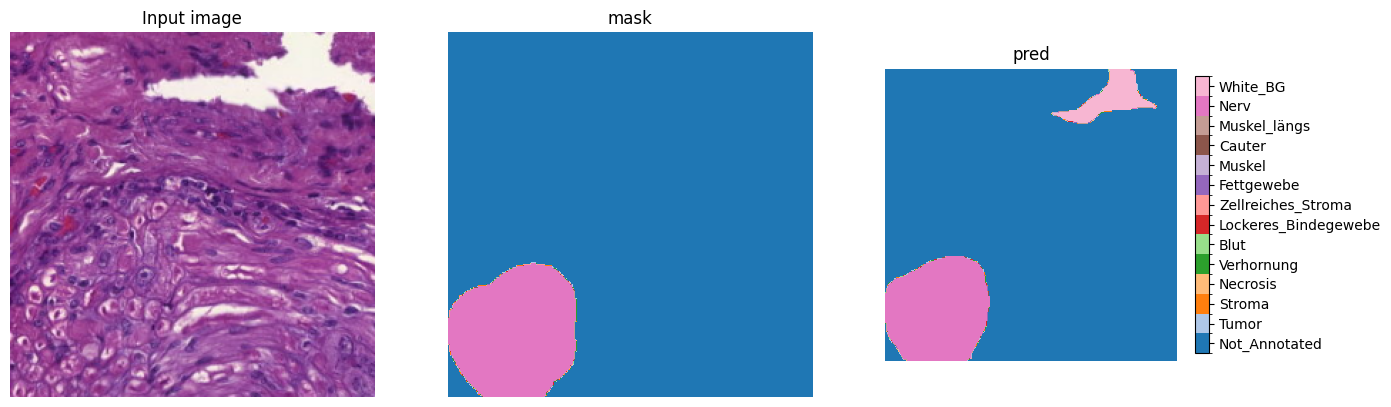

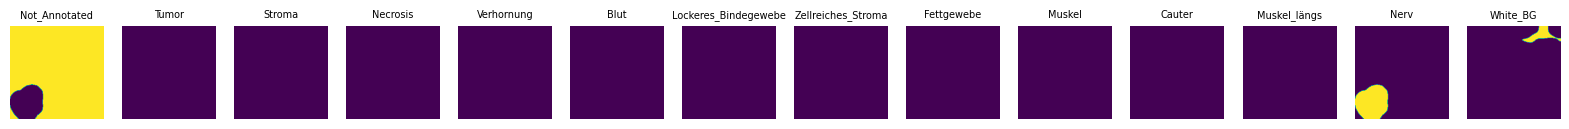

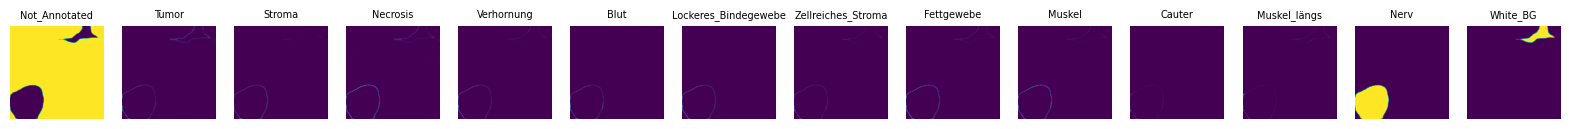

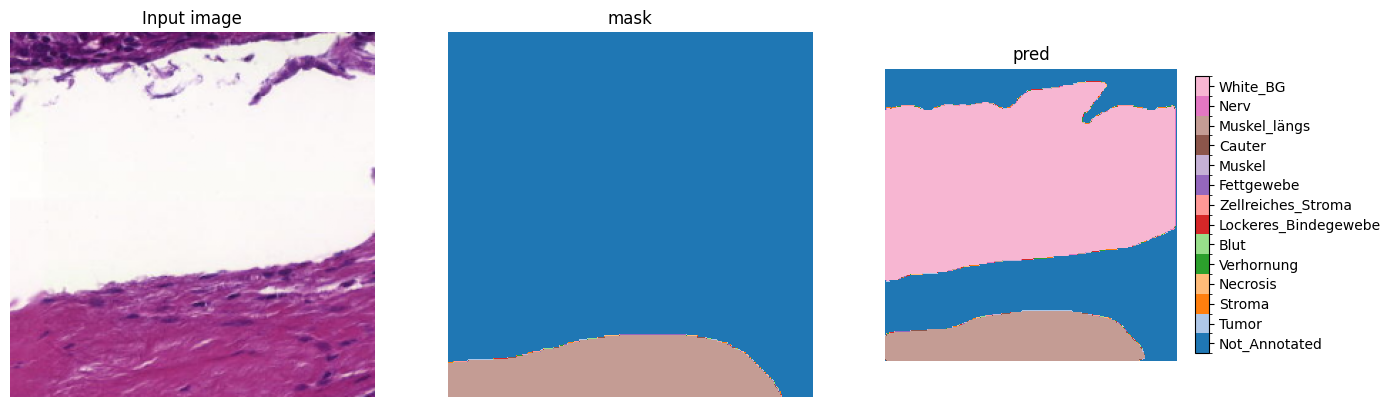

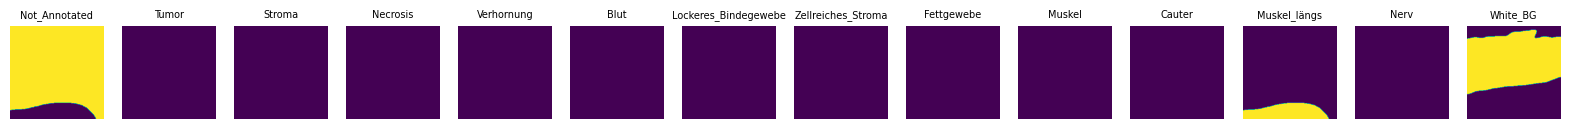

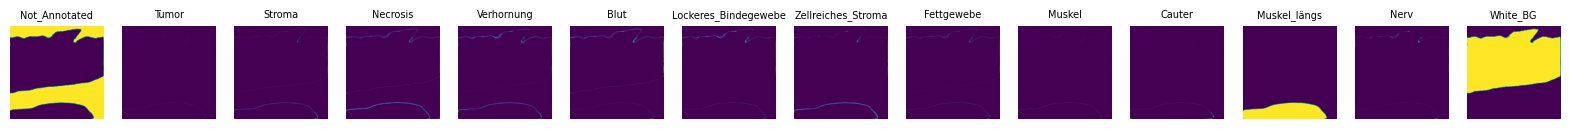

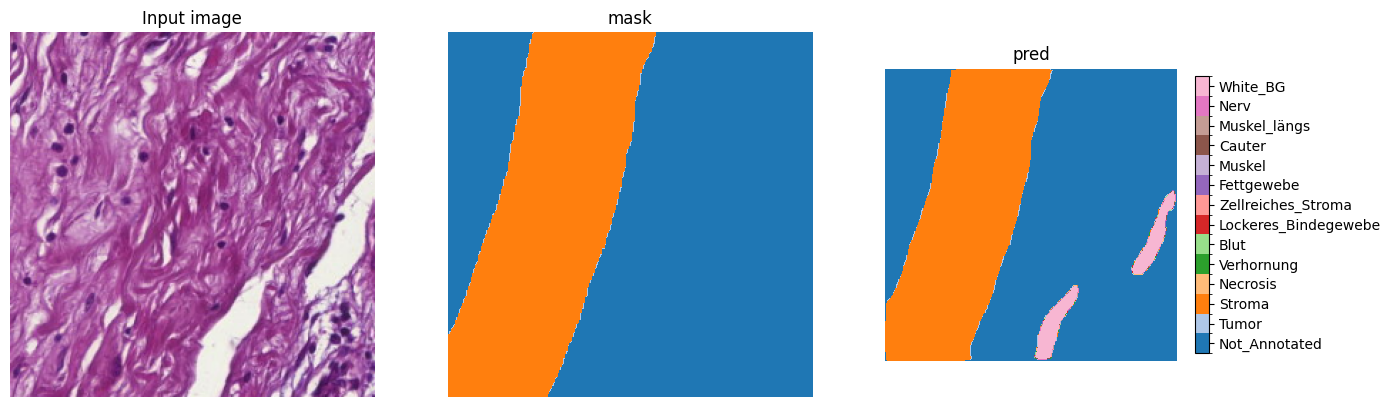

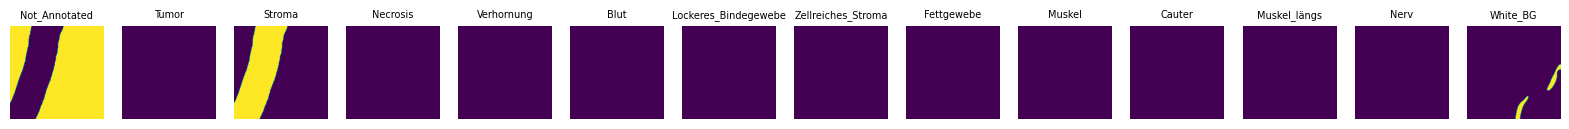

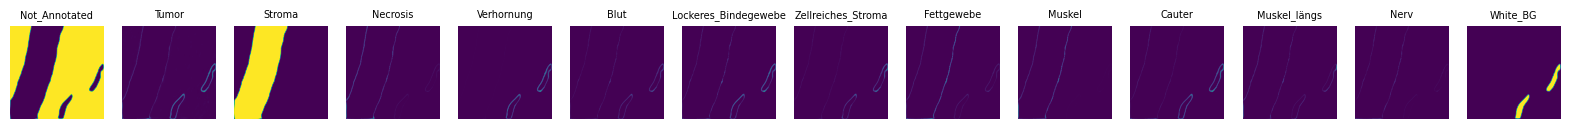

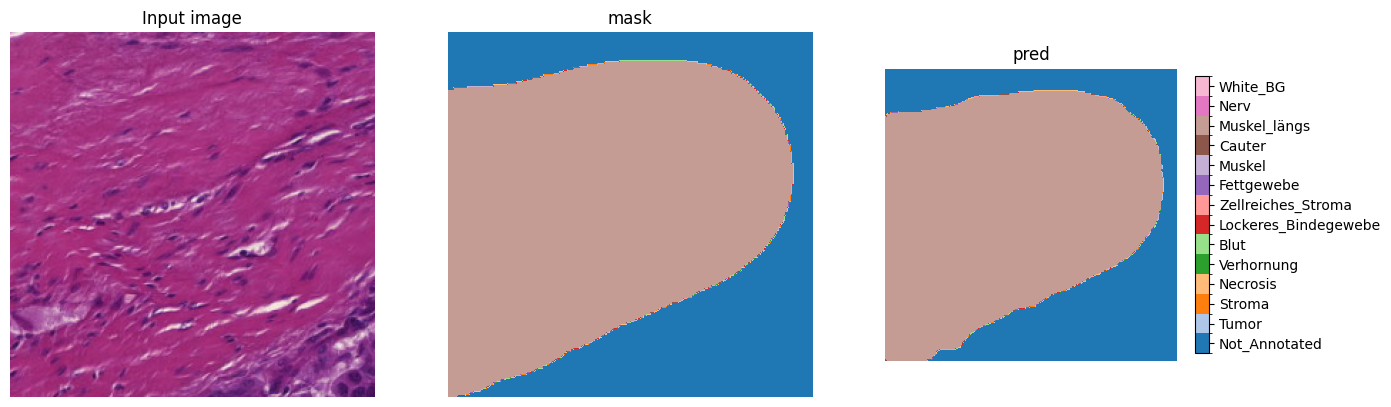

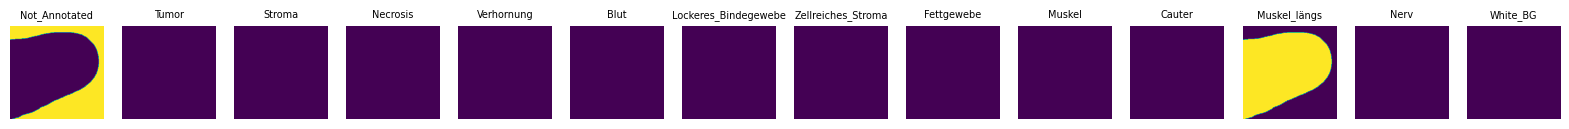

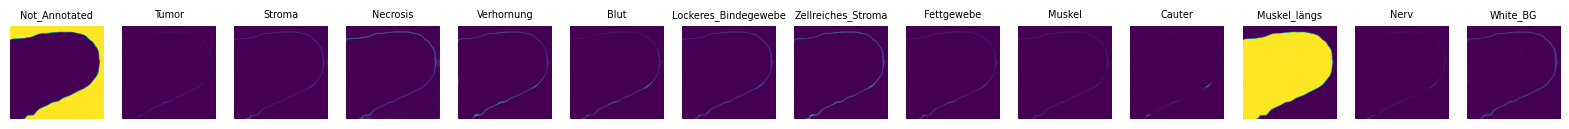

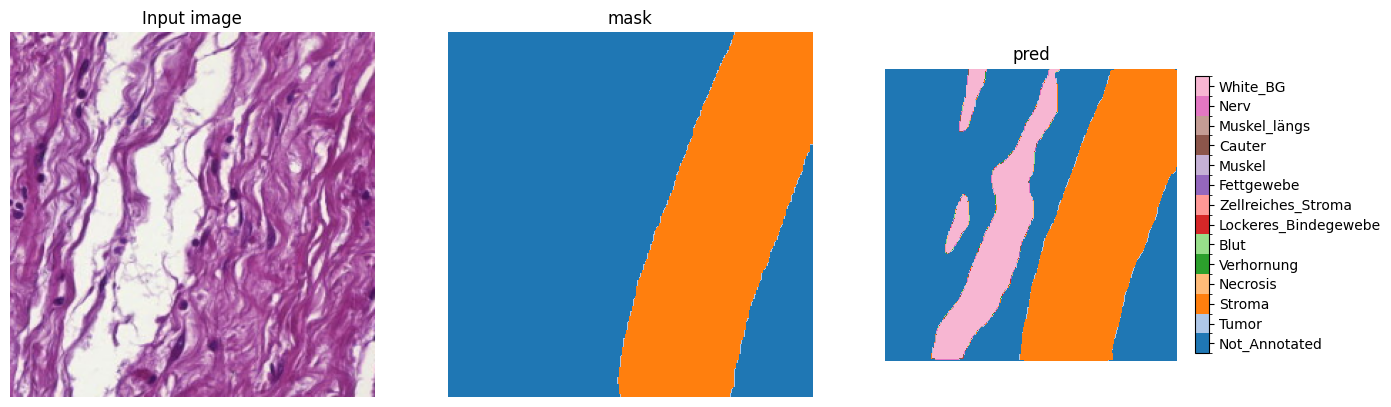

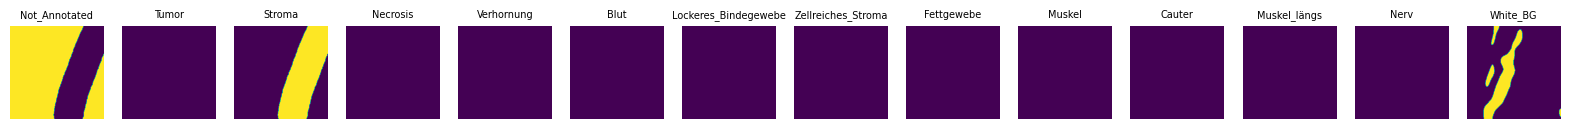

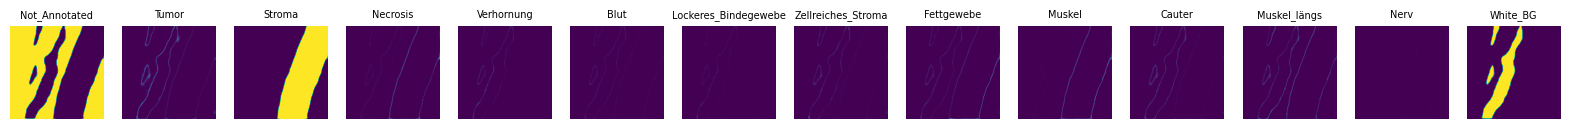

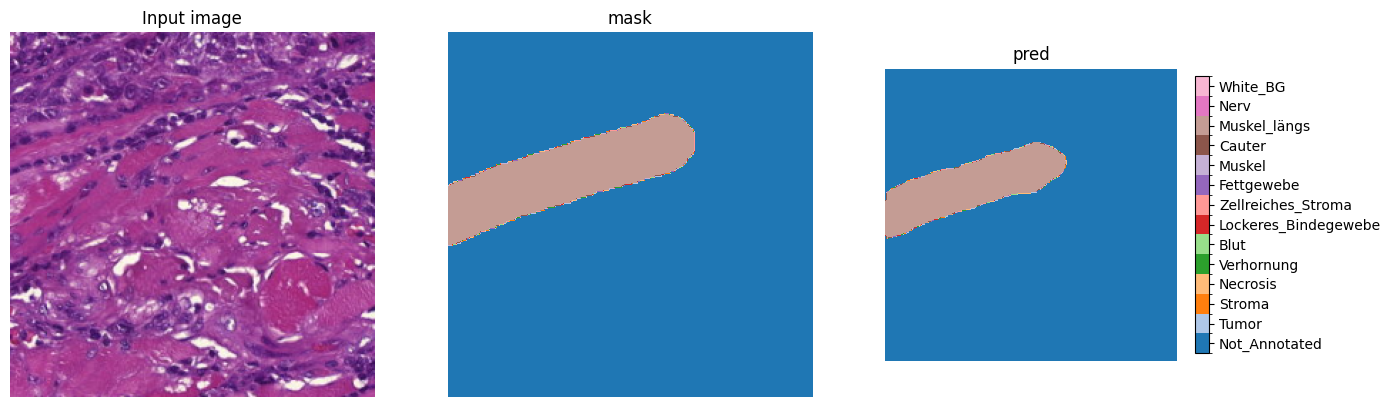

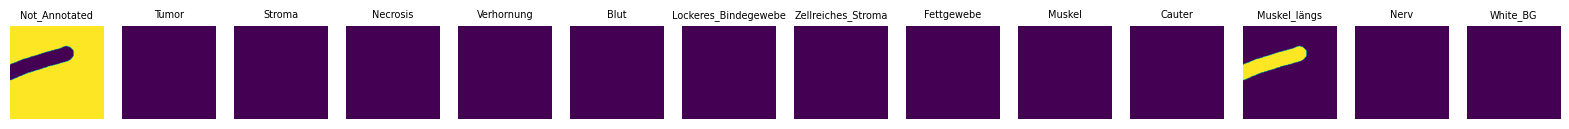

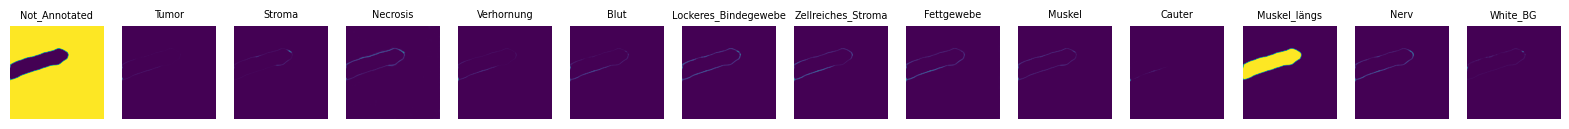


KeyboardInterrupt



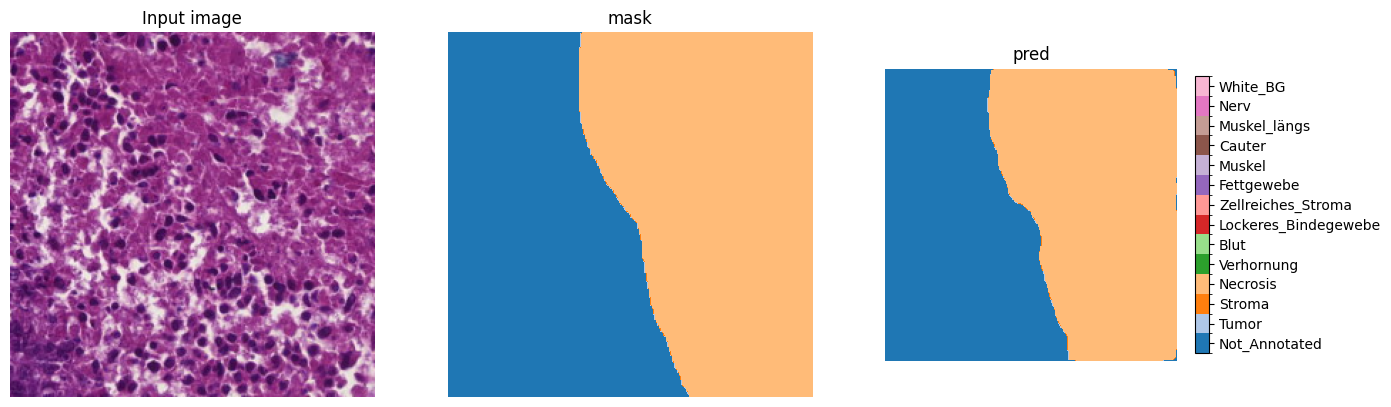

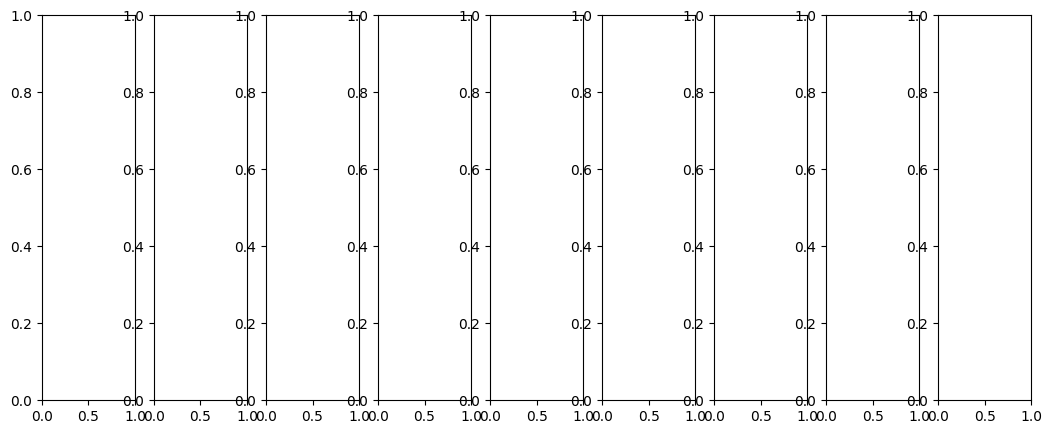

In [39]:
# Normal

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm


DataGen = DataGenerator(full_set_x,full_set_y, batch_size=30, aug=False)
img, mask = DataGen.__getitem__(0)
y_pred = model.predict(img)


for idx in range(np.shape(y_pred)[0]):
    # Plot the input image in the first subplot
   # Create the figure and axis
    fig, ax = plt.subplots(1, 3, figsize=(16, 12))

    # Plot the input image
    ax[0].imshow(img[idx])
    ax[0].set_title('Input image')
    ax[0].axis('off')

    empty = np.zeros((256, 256))
    # Loop through the images and plot them
    ans = np.argmax(mask[idx],axis=2)

    # Create a custom discrete colormap with 13 colors
    cmap = ListedColormap(plt.cm.tab20.colors[:14])
    bounds = np.arange(0, 15) -0.5 # Set boundaries of color segments
    norm = BoundaryNorm(bounds, cmap.N)
    ax[1].axis('off')

    im = ax[1].imshow(ans, cmap=cmap, norm=norm)
    ax[1].set_title('mask')

    empty = np.zeros((256, 256))
    # Loop through the images and plot them
    ans = np.argmax(y_pred[idx],axis=2)

    # Create a custom discrete colormap with 13 colors
    cmap = ListedColormap(plt.cm.tab20.colors[:14])
    ax[2].axis('off')


    im = ax[2].imshow(ans, cmap=cmap, norm=norm)
    ax[2].set_title('pred')

    # Add colorbar next to the second plot
    cbar = plt.colorbar(im, ax=ax[2], ticks=np.arange(0, 14), shrink=0.3)
    cbar.set_ticklabels(class_names)


    ##################################

    # Create the subplots
    fig, axs = plt.subplots(1, 14, figsize=(20, 5))

    # Loop through each subplot
    for i, ax in enumerate(axs.flat):
        ax.imshow(mask[idx][:, :, i])
        ax.axis('off')
        ans = np.mean(mask[idx][:, :, i])
        ax.set_title(f'{class_names[i]}', fontsize=7)

    plt.show()



    ###########################################

    # Create the subplots
    fig, axs = plt.subplots(1, 14, figsize=(20, 5))

    # Loop through each subplot
    for i, ax in enumerate(axs.flat):
        ax.imshow(y_pred[idx][:, :, i])
        ax.axis('off')
        ans = np.mean(y_pred[idx][:, :, i])
        ax.set_title(f'{class_names[i]}', fontsize=7)

    plt.show()
